## 1. Importing Dependencies and Initial Setup

In [1]:
# Utilities for storage and logging
import logging
import os
from pathlib import Path
import pickle

# Data handling and computation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Display plots inline to Jupyter Notebook
%matplotlib inline

# Paths
datapath = Path("../data/superstore.csv") # Dataset path
state_path = Path("../store/state_dump.pkl") # Application state storage

# Pandas display options
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# Logging Configuration
logging.basicConfig(
    level = logging.INFO,       # For verbose logging
    # level = logging.ERROR     # For logging only errors
    format = "%(levelname)s: %(message)s"
)

# Fix random seed for reproducibility
np.random.seed(42)
np.set_printoptions(precision = 5)

# Create application storage directory if it does not exist
try:
    os.makedirs("../store")
except FileExistsError:
    logging.warning("Existing files from a previous run may be overwritten.")

# Initialize dictionary to store application-wide state
state_holder = dict()

# Confidence interval for prophet
confidence_interval = 0.8
state_holder["confidence_interval"] = confidence_interval

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percent_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))

# Print errors
def print_errors(title, errors, mape):
    print(f"\n{title}")
    print("-" * len(title))
    for metric, value in errors.items():
        print(f"{metric:<5}: {value:.3f}")
    print(f"MAPE : {mape*100:.3f} %")

logging.info("Initial Setup Process Complete")

INFO: Initial Setup Process Complete


## 2. Dataset Fetch

In [2]:
try:
    # Load dataset twice, one for model training and other preserved for application state 
    df = pd.read_csv(datapath, encoding = "latin1")
    df1 = pd.read_csv(datapath, encoding = "latin1")

    # Convert order and shipping dates to datetime datatype and sorting them with Order Date
    df["Order Date"] = pd.to_datetime(df["Order Date"])
    df["Ship Date"] = pd.to_datetime(df["Ship Date"])
    df = df.sort_values("Order Date").reset_index(drop = True)

    df1["Order Date"] = pd.to_datetime(df1["Order Date"])
    df1["Ship Date"] = pd.to_datetime(df1["Ship Date"])
    df1 = df1.sort_values("Order Date").reset_index(drop = True)

    # Store dataset for application usage
    state_holder["dataframe"] = df1
except FileNotFoundError:
    logging.error("Dataset is not found, please check the dataset path and try again")
    raise
except Exception as e:
    logging.error(f"Failed to load dataset {e}")
finally:
    if "df" in locals():
        logging.info(f"Dataset shape received: {df.shape}")
    logging.info("Dataset loading process completed")

INFO: Dataset shape received: (9994, 21)
INFO: Dataset loading process completed


## 3. Dataset Analysis

Showing first 5 rows of the dataset.

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
3,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
4,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


Showing the dataset columns.

In [4]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Showing missing values in the dataset.

In [5]:
missing_values = {}
for i in df.columns:
    val = df[i].isna().sum()
    if val > 0:
        missing_values[i] = val

# Store missing values for application 
state_holder["missing_values"] = missing_values

if missing_values:
    print("Missing values: ")
    for i in missing_values:
        print(f"{i} = {missing_values[i]}")

    missing_values_df = (
        pd.DataFrame.from_dict(missing_values, orient = "index", columns = ["Missing Count"])
        .sort_values("Missing Count", ascending = False)
    )
    
    plt.figure(figsize = (10, 4))
    sns.barplot(
        data = missing_values_df,
        x = "index", 
        y = "Missing Count"
    )
    plt.title("Missing Values Count per Column")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset")

No missing values found in the dataset


Showing duplicate entries in the dataset.

In [6]:
duplicate_entries = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_entries)}")
if not duplicate_entries.empty:
    duplicate_entries.head()

# Store duplicate entries for application usage
state_holder["duplicate_entries"] = duplicate_entries

Number of duplicate rows: 0


Showing invalid sales record in the dataset.

In [7]:
invalid_sales = df[df['Sales'] <= 0]    # Zero or negative sales values are considered invalid
print(f"Invalid sales records: {len(invalid_sales)}")
if not invalid_sales.empty:
    invalid_sales.head()

# Store invalid sales records for application usage
state_holder["invalid_sales"] = invalid_sales

Invalid sales records: 0


Showing columns and unique values in each column.

In [8]:
categorical_cols = ["Ship Mode", "Segment", "Country", "Region", "Category", "Sub-Category"]

categorical_info = pd.DataFrame({
    "Column": categorical_cols,
    "Unique_Values": [df[i].unique() for i in categorical_cols],
    "Unique_Count": [df[i].nunique() for i in categorical_cols]
})

# Store categorical column metadata for application usage
state_holder["categorical_cols"] = categorical_cols
state_holder["categorical_info"] = categorical_info
categorical_info

,Column,Unique_Values,Unique_Count
0,Ship Mode,"[Standard Class, First Class, Second Class, Sa...",4
1,Segment,"[Consumer, Home Office, Corporate]",3
2,Country,[United States],1
3,Region,"[Central, East, South, West]",4
4,Category,"[Office Supplies, Furniture, Technology]",3
5,Sub-Category,"[Paper, Labels, Storage, Binders, Art, Chairs,...",17


Showing monthly sales outliers in the dataset.

Detected outliers: 1167


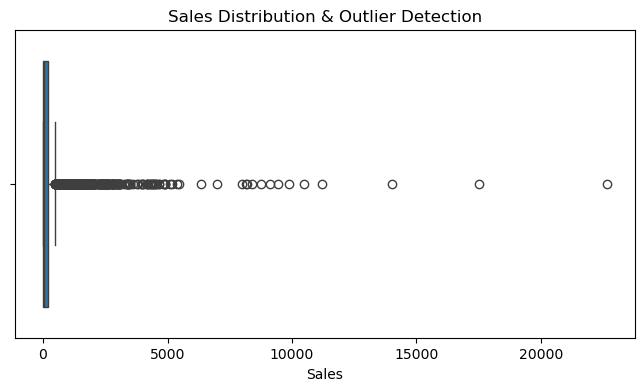

In [9]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Sales'] < Q1 - 1.5 * IQR) | (df['Sales'] > Q3 + 1.5 * IQR)]
print(f"Detected outliers: {len(outliers)}")

plt.figure(figsize = (8, 4))
sns.boxplot(x = df['Sales'])
plt.title("Sales Distribution & Outlier Detection")
plt.show()

# Store detected outliers for application usage
state_holder["outliers"] = outliers

Showing missing dates in the dataset.

In [10]:
full_date_range = pd.date_range(
    start = df['Order Date'].min(),
    end = df['Order Date'].max(),
    freq = 'D'
)

missing_dates = full_date_range.difference(df['Order Date'].unique())
print(f"Missing dates in time series: {len(missing_dates)}")

# Store missing dates information for application usage
state_holder["missing_dates"] = missing_dates.to_frame(index = False)

Missing dates in time series: 221


### Insights

1. The dataset contains no missing values, duplicate entries, or invalid sales records, providing a strong foundation for forecasting.
2. Sales outliers were observed and are likely driven by factors such as promotional discounts and seasonal demand spikes.
3. Certain dates are missing from the time series, most likely due to non-operational days (e.g., holidays or weekends), as no explicit holiday information is provided.
4. The Prophet model can handle missing dates and irregular time series without requiring synthetic data imputation. Additionally, sales outliers represent real business events and should be preserved to train the model under realistic conditions.


## 4. Exploratory Data Analysis (EDA)

Showing descriptive Statistical Analysis.

In [11]:
df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


Range of order dates covered by the dataset.

In [12]:
print("Range of order dates: ")
print(f"Range of order dates: {df['Order Date'].min()} to {df['Order Date'].max()}")

Range of order dates: 
Range of order dates: 2014-01-03 00:00:00 to 2017-12-30 00:00:00


### Monthly Sales Trend

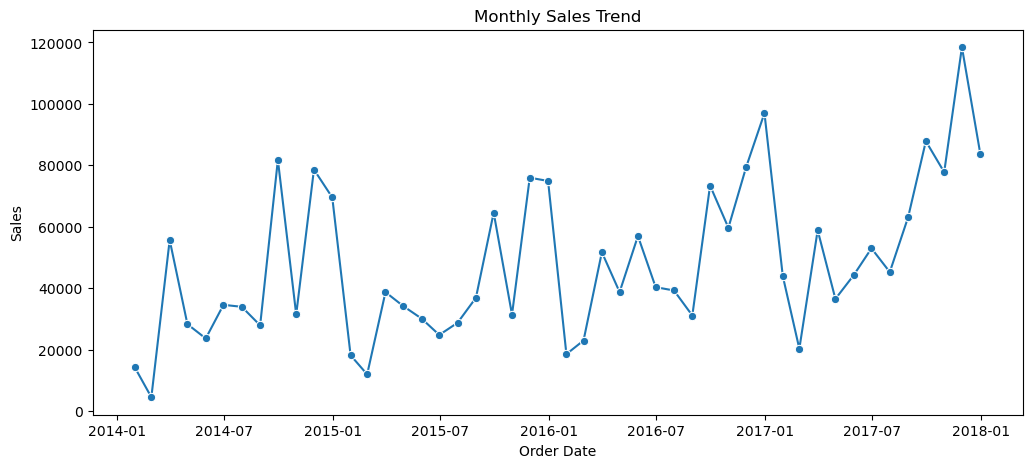

In [13]:
# Aggregate monthly sales
monthly_sales = (
    df
    .groupby(pd.Grouper(key = "Order Date", freq = "ME"))["Sales"]
    .sum()
    .reset_index()
)

plt.figure(figsize = (12, 5))
sns.lineplot(
    data = monthly_sales,
    x = "Order Date", 
    y = "Sales", 
    marker = "o"
)
plt.title("Monthly Sales Trend")
plt.show()

# Store monthly sales data for application usage
state_holder["monthly_sales"] = monthly_sales

### Average Sales by Month

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


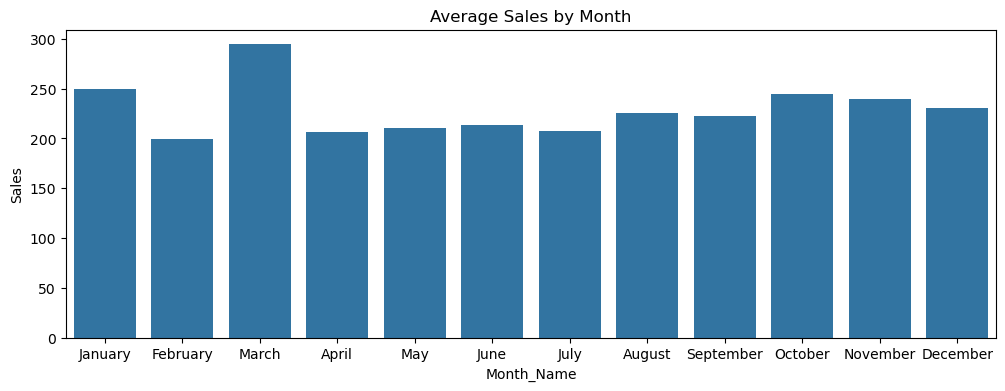

In [14]:
df["Month"] = df["Order Date"].dt.month
df["Month_Name"] = df["Order Date"].dt.month_name()

monthly_avg = (
    df.groupby(["Month", "Month_Name"], as_index=False)["Sales"]
    .mean()
    .reset_index()
    .sort_values("Month")
)

plt.figure(figsize = (12, 4))
sns.barplot(
    data = monthly_avg,
    x = "Month_Name", 
    y = "Sales"
)
plt.title("Average Sales by Month")
plt.show()

# Store monthly average sales data for application usage
state_holder["monthly_avg"] = monthly_avg

### Total Sales by Category 

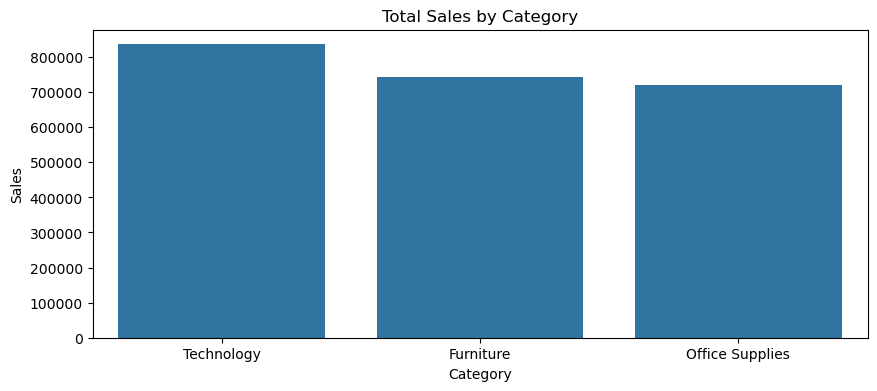

In [15]:
category_sales = (
    df.groupby("Category")["Sales"]
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

plt.figure(figsize = (10, 4))
sns.barplot(
    data = category_sales,
    x = "Category",
    y = "Sales"
)
plt.title("Total Sales by Category")
plt.show()

# Store category-wise sales data for application usage
state_holder["category_sales"] = category_sales

### Total Sales by Region

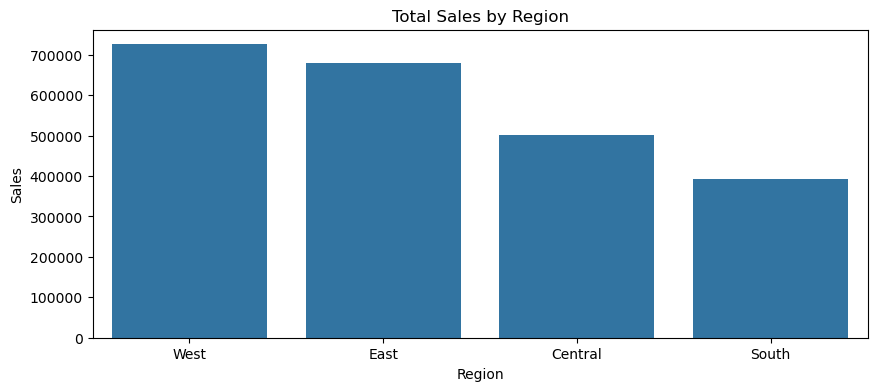

In [16]:
region_sales = (
    df.groupby("Region")["Sales"]
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

plt.figure(figsize = (10, 4))
sns.barplot(
    data = region_sales,
    x = "Region",
    y = "Sales"
)
plt.title("Total Sales by Region")
plt.show()

# Store region-wise sales data for application usage
state_holder["region_sales"] = region_sales

### Total Sales by Segment

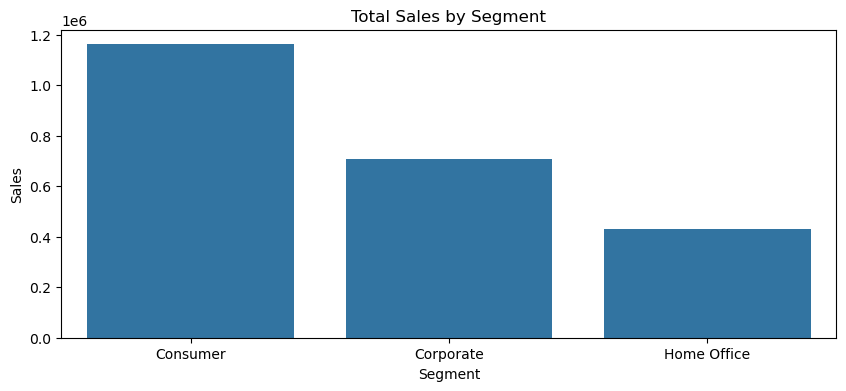

In [17]:
segment_sales = (
    df.groupby("Segment")["Sales"]
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

plt.figure(figsize = (10, 4))
sns.barplot(
    data = segment_sales,
    x = "Segment",
    y = "Sales"
)
plt.title("Total Sales by Segment")
plt.show()

# Store segment-wise sales data for application usage
state_holder["segment_sales"] = segment_sales

### Box Plot for Monthly Sales

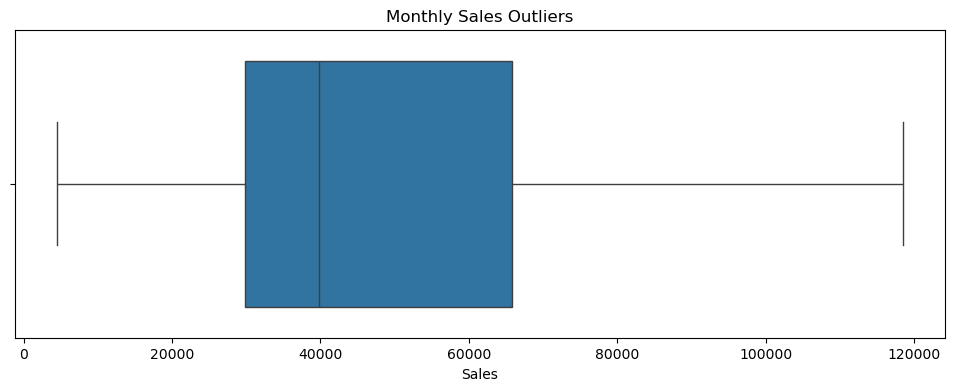

In [18]:
plt.figure(figsize = (12, 4))
sns.boxplot(
    x = monthly_sales["Sales"],
    orientation = "horizontal"
)
plt.title("Monthly Sales Outliers")
plt.show()

### Daily Sales Trend Over Time

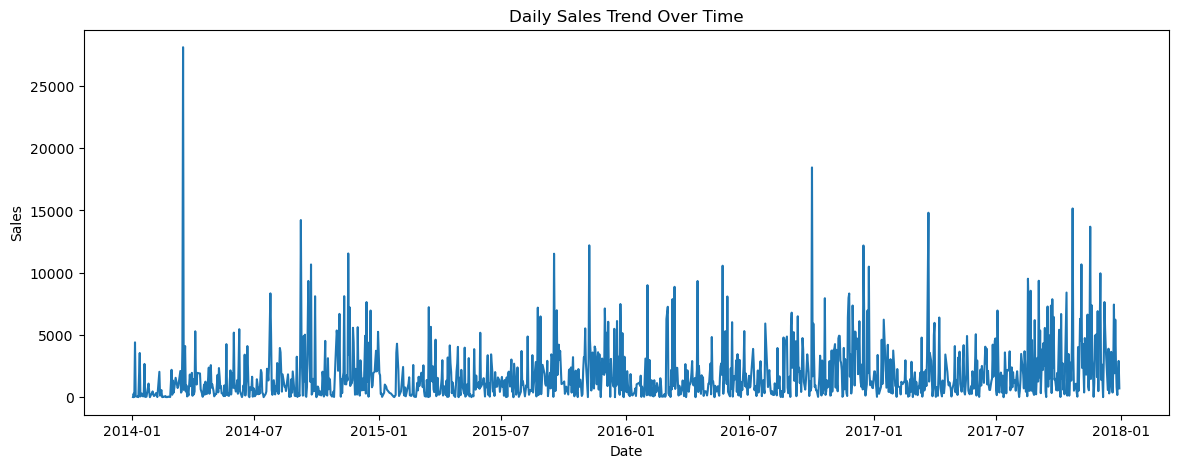

In [19]:
time_series_daily = (
    df.groupby("Order Date")["Sales"]
    .sum()
    .reset_index()
    .sort_values("Order Date")
)

plt.figure(figsize = (14, 5))
sns.lineplot(
    data = time_series_daily,
    x = "Order Date",
    y = "Sales"
)
plt.title("Daily Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

### Rolling Mean and Volatility (30-Day Window)

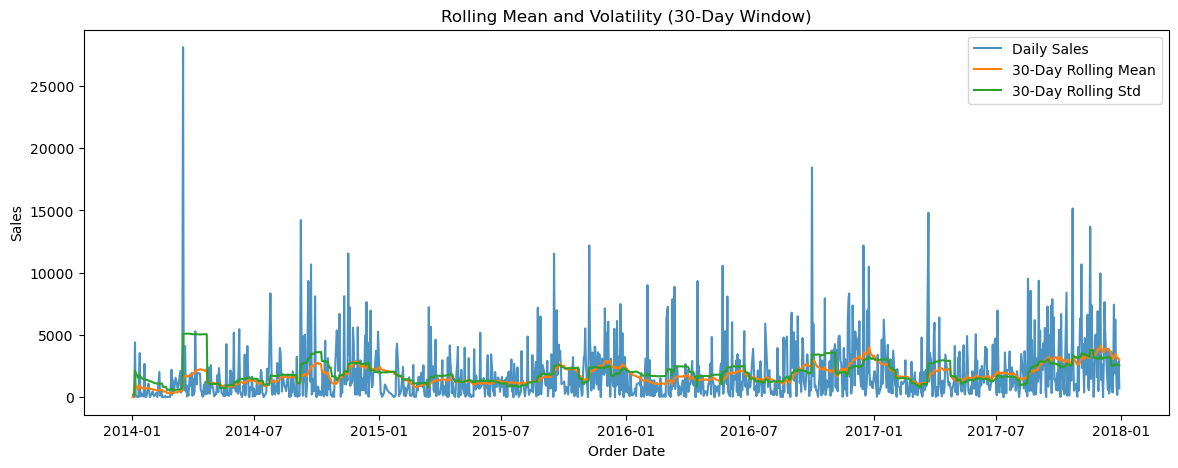

In [20]:
time_series_daily["Rolling_Mean_30"] = time_series_daily["Sales"].rolling(window=30, min_periods=1).mean()
time_series_daily["Rolling_Std_30"] = time_series_daily["Sales"].rolling(window=30, min_periods=1).std()

plt.figure(figsize = (14, 5))
# Daily sales
sns.lineplot(
    data = time_series_daily,
    x = "Order Date",
    y = "Sales",
    label = "Daily Sales",
    alpha = 0.8
)

# Rolling mean
sns.lineplot(
    data = time_series_daily,
    x = "Order Date",
    y = "Rolling_Mean_30",
    label = "30-Day Rolling Mean"
)

# Rolling std (volatility)
sns.lineplot(
    data = time_series_daily,
    x = "Order Date",
    y = "Rolling_Std_30",
    label = "30-Day Rolling Std"
)

plt.title("Rolling Mean and Volatility (30-Day Window)")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Average Sales by Day of Week

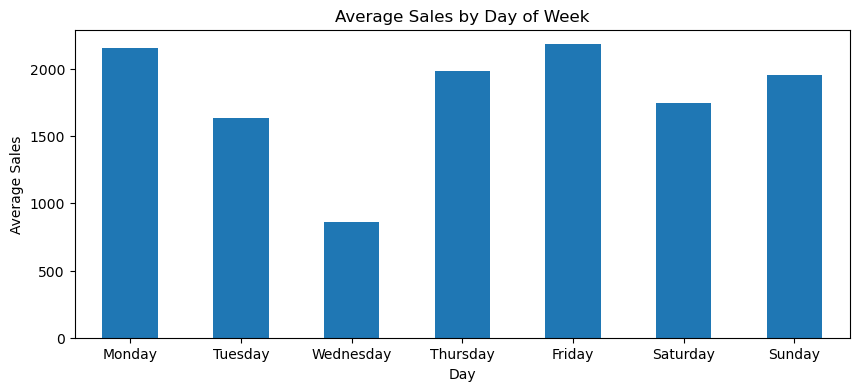

In [21]:
time_series_daily["DayOfWeek"] = time_series_daily["Order Date"].dt.day_name()

plt.figure(figsize = (10, 4))
time_series_daily.groupby("DayOfWeek")["Sales"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
).plot(kind="bar")
plt.title("Average Sales by Day of Week")
plt.xlabel("Day")
plt.ylabel("Average Sales")
plt.xticks(rotation=0)
plt.show()

In [22]:
# Store daily time series data for application usage
state_holder["time_series_daily"] = time_series_daily

### Insights

1. Sales exhibit a clear upward trend, indicating consistent business growth over time.
2. Seasonal patterns are evident at the monthly level, confirming the need for a seasonality-aware forecasting model.
3. Revenue contribution varies significantly across product categories and regions, justifying granular analysis.
4. Sales outliers reflect genuine demand spikes (e.g., promotions or bulk orders) and were retained for realistic modeling.
5. Daily sales show high volatility; monthly aggregation smooths noise and provides more stable forecasting signals.

## 5. Data Preprocessing

Split the time series data into training and testing periods.

In [23]:
split_date = pd.to_datetime("2017-01-01")
X_train = monthly_sales[monthly_sales["Order Date"] < split_date]
X_test   = monthly_sales[monthly_sales["Order Date"] >= split_date]
print("Train period:", X_train["Order Date"].min(), "to", X_train["Order Date"].max())
print("Test period:", X_test["Order Date"].min(), "to", X_test["Order Date"].max())

# Store test dataset for application usage
state_holder["test"] = X_test

Train period: 2014-01-31 00:00:00 to 2016-12-31 00:00:00
Test period: 2017-01-31 00:00:00 to 2017-12-31 00:00:00


Visualize the train–test split of the time series data.

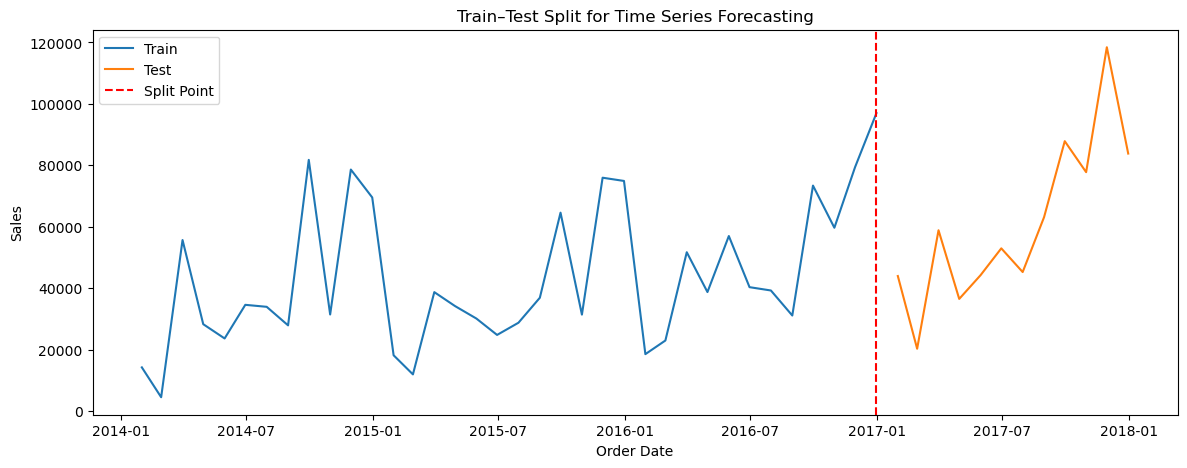

In [24]:
plt.figure(figsize=(14, 5))
sns.lineplot(
    data = X_train,
    x = "Order Date",
    y = "Sales", 
    label="Train"
)
sns.lineplot(
    data = X_test,
    x = "Order Date",
    y = "Sales", 
    label="Test"
)
plt.axvline(X_train["Order Date"].iloc[-1], color="red", linestyle="--", label="Split Point")
plt.legend()
plt.title("Train–Test Split for Time Series Forecasting")
plt.show()

## 6. Baseline Forecast

### Naïve Forecast

In [25]:
train = X_train.copy()
test = X_test.copy()
last_value = train["Sales"].iloc[-1]
naive_forecast = [last_value] * len(test)
test["naive_forecast"] = naive_forecast

### Moving Average Forecast

In [26]:
window = 3
ma_value = train["Sales"].rolling(window).mean().iloc[-1]
ma_forecast = [ma_value] * len(test)
test["ma_forecast"] = ma_forecast

### Seasonal Naïve Forecast

In [27]:
# Use last 12 months to capture yearly seasonality

seasonal_naive = train["Sales"].iloc[-12:].values
seasonal_forecast = list(seasonal_naive) * (len(test) // 12 + 1)
seasonal_forecast = seasonal_forecast[:len(test)]
test["seasonal_naive_forecast"] = seasonal_forecast

### Baseline Forecast Models Comparison

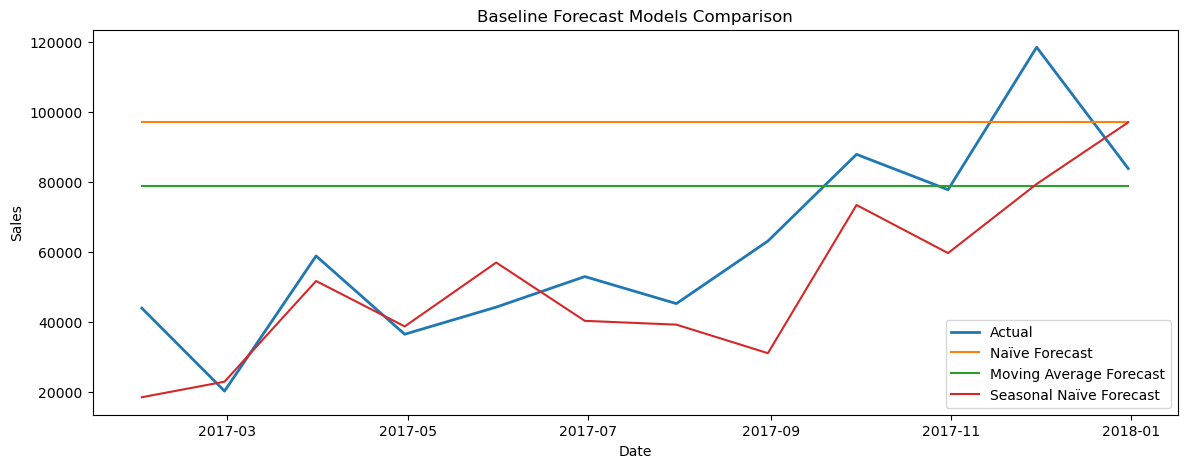

In [28]:
plt.figure(figsize = (14, 5))

# Actual sales
sns.lineplot(
    data=test,
    x="Order Date",
    y="Sales",
    label="Actual",
    linewidth=2
)

# Naïve forecast
sns.lineplot(
    data=test,
    x="Order Date",
    y="naive_forecast",
    label="Naïve Forecast"
)

# Moving average forecast
sns.lineplot(
    data=test,
    x="Order Date",
    y="ma_forecast",
    label="Moving Average Forecast"
)

# Seasonal naïve forecast
sns.lineplot(
    data=test,
    x="Order Date",
    y="seasonal_naive_forecast",
    label="Seasonal Naïve Forecast"
)

plt.title("Baseline Forecast Models Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Store baseline forecast results for application usage
state_holder["baseline_forecasts"] = test

## 7. Baseline Model Analysis

In [29]:
y_test = test["Sales"]
y_pred_naive = test["naive_forecast"]
y_pred_ma = test["ma_forecast"]
y_pred_seasonal = test["seasonal_naive_forecast"]

Error metrics for Baseline forecast models.

In [30]:
# Naïve Forecast Errors
errors_naive = {
    "MSE": mean_squared_error(y_test, y_pred_naive),
    "MAE": mean_absolute_error(y_test, y_pred_naive),
    "RMSE": root_mean_squared_error(y_test, y_pred_naive),
}
mape_naive = mean_absolute_percent_error(y_test, y_pred_naive)

# Moving Average Forecast Errors
errors_ma = {
    "MSE": mean_squared_error(y_test, y_pred_ma),
    "MAE": mean_absolute_error(y_test, y_pred_ma),
    "RMSE": root_mean_squared_error(y_test, y_pred_ma),
}
mape_ma = mean_absolute_percent_error(y_test, y_pred_ma)

# Seasonal Naïve Forecast Errors
errors_seasonal = {
    "MSE": mean_squared_error(y_test, y_pred_seasonal),
    "MAE": mean_absolute_error(y_test, y_pred_seasonal),
    "RMSE": root_mean_squared_error(y_test, y_pred_seasonal),
}
mape_seasonal = mean_absolute_percent_error(y_test, y_pred_seasonal)

print_errors("Naïve Forecast Errors", errors_naive, mape_naive)
print_errors("Moving Average Forecast Errors", errors_ma, mape_ma)
print_errors("Seasonal Naïve Forecast Errors", errors_seasonal, mape_seasonal)


Naïve Forecast Errors
---------------------
MSE  : 1952922791.512
MAE  : 39472.569
RMSE : 44191.886
MAPE : 97.323 %

Moving Average Forecast Errors
------------------------------
MSE  : 973973408.271
MAE  : 26605.820
RMSE : 31208.547
MAPE : 66.000 %

Seasonal Naïve Forecast Errors
------------------------------
MSE  : 360456633.917
MAE  : 15467.893
RMSE : 18985.696
MAPE : 24.519 %


## 8. Prophet Model for Evaluation

1. Trained on historical training data.
2. Use to evaluate forecasting accuracy and comparison against baseline models.

In [31]:
X_train_prophet = (
    X_train
    .rename(columns = {
        "Order Date": "ds",
        "Sales": "y"
    })
)

X_test_prophet = (
    X_test
    .rename(columns = {
        "Order Date": "ds",
        "Sales": "y"
    })
)

In [32]:
model_test = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    interval_width = confidence_interval
)

model_test.fit(X_train_prophet)

INFO: Chain [1] start processing
INFO: Chain [1] done processing


Generating future sales predictions using Prophet model.

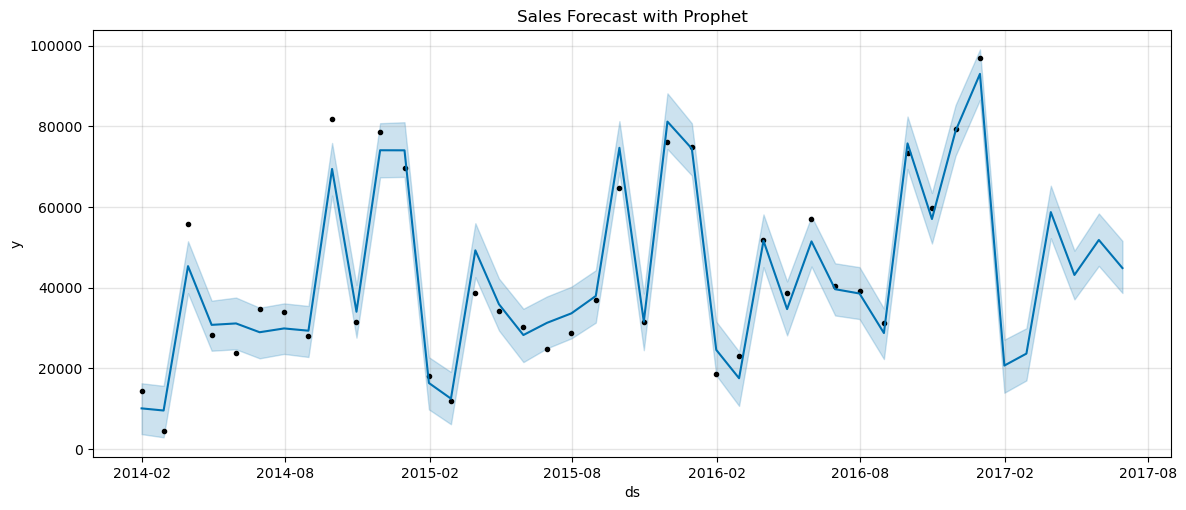

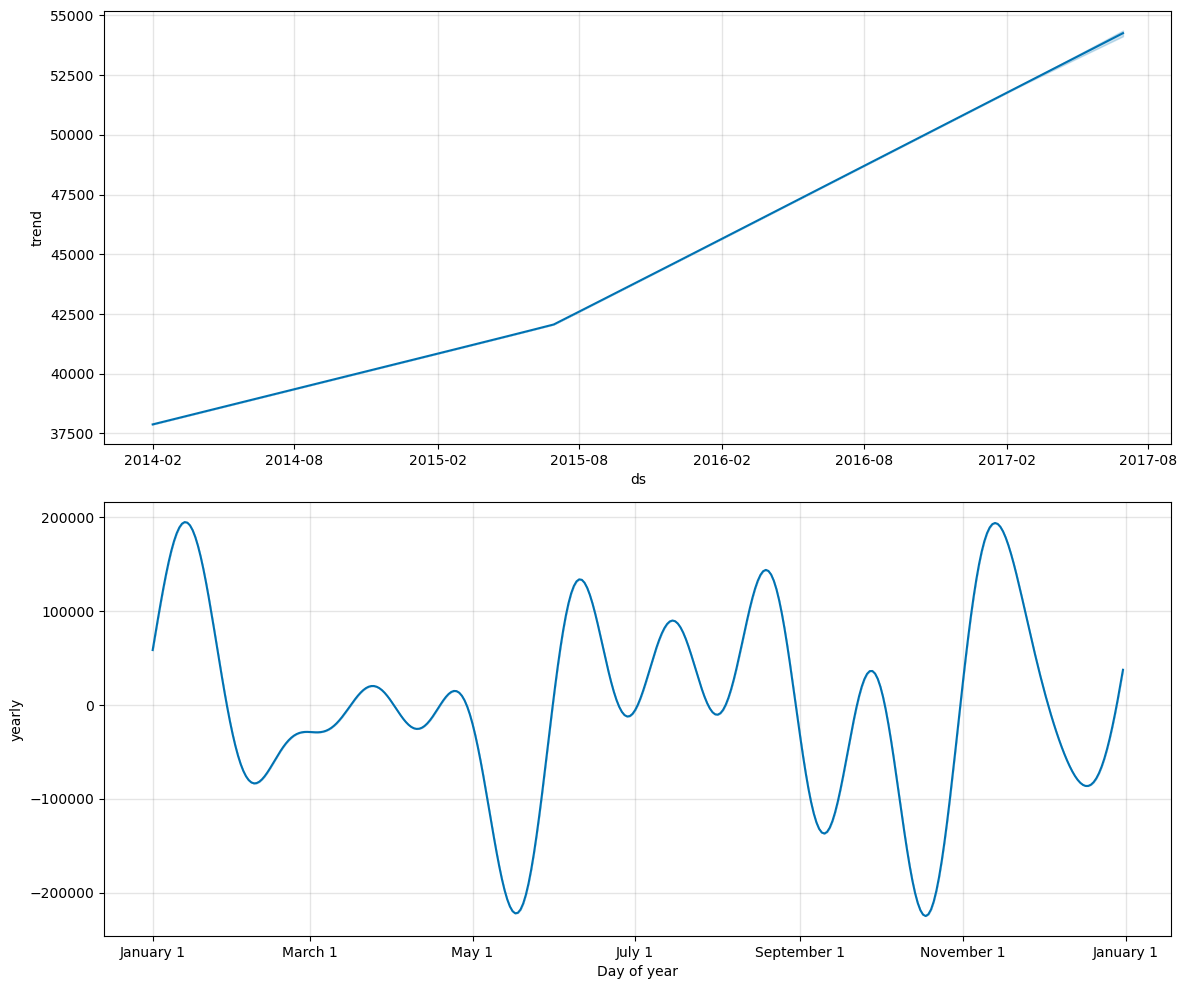

In [33]:
future = model_test.make_future_dataframe(periods=6, freq="ME")
forecast = model_test.predict(future)
forecast.head()

model_test.plot(forecast, figsize = (12, 5))
plt.title("Sales Forecast with Prophet")
plt.show()

model_test.plot_components(forecast, figsize = (12, 10))
plt.show()

In [34]:
forecast_output = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_output.head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-31,10037.891964,3654.396645,16264.852915
1,2014-02-28,9507.871066,2860.321378,15626.170134
2,2014-03-31,45307.002267,38596.025832,51472.202917
3,2014-04-30,30744.352468,24326.500369,36739.894978
4,2014-05-31,31099.810770,24689.228491,37511.846102


## 9. Prophet Model Analysis and Comparison

In [35]:
forecast_test = model_test.predict(X_test_prophet[["ds"]])
y_pred = forecast_test["yhat"].values
y_test = X_test_prophet["y"].values

# Store Prophet predictions for test data for application usage
state_holder["prophet_forecasts"] = forecast_test

Error metrics for Prophet forecast.

In [36]:
errors_prophet = {
    "MSE": mean_squared_error(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
}
mape_prophet = mean_absolute_percent_error(y_test, y_pred)
print_errors("Prophet", errors_prophet, mape_prophet)


Prophet
-------
MSE  : 232640039.921
MAE  : 11648.917
RMSE : 15252.542
MAPE : 19.067 %


Compare error metrics across all forecasting models.

In [37]:
comparison = pd.DataFrame({
    "Model": ["Naïve", "Moving Average", "Seasonal Naïve", "Prophet"],
    "MSE": [errors_naive["MSE"], errors_ma["MSE"], errors_seasonal["MSE"], errors_prophet["MSE"]],
    "MAE": [errors_naive["MAE"], errors_ma["MAE"], errors_seasonal["MAE"], errors_prophet["MAE"]],
    "RMSE": [errors_naive["RMSE"], errors_ma["RMSE"], errors_seasonal["RMSE"], errors_prophet["RMSE"]],
    "MAPE": [mape_naive, mape_ma, mape_seasonal, mape_prophet]
})
comparison = comparison.set_index("Model")

# Store model error comparison table for application usage
state_holder["errors"] = comparison
comparison

,MSE,MAE,RMSE,MAPE
Model,,,,
Naïve,1.952923e+09,39472.568733,44191.886037,0.973231
Moving Average,9.739734e+08,26605.820333,31208.547039,0.659999
Seasonal Naïve,3.604566e+08,15467.892517,18985.695508,0.245189
Prophet,2.326400e+08,11648.917405,15252.542081,0.190669


### Residual Analysis for Prophet

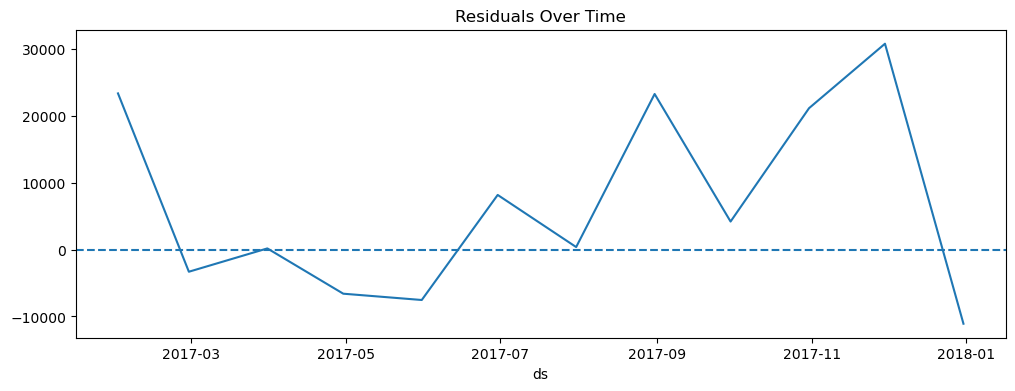

In [38]:
residual = y_test - y_pred

plt.figure(figsize=(12,4))
sns.lineplot(
    data = X_test_prophet,
    x = "ds", 
    y = residual
)
plt.axhline(0, linestyle="--")
plt.title("Residuals Over Time")
plt.show()

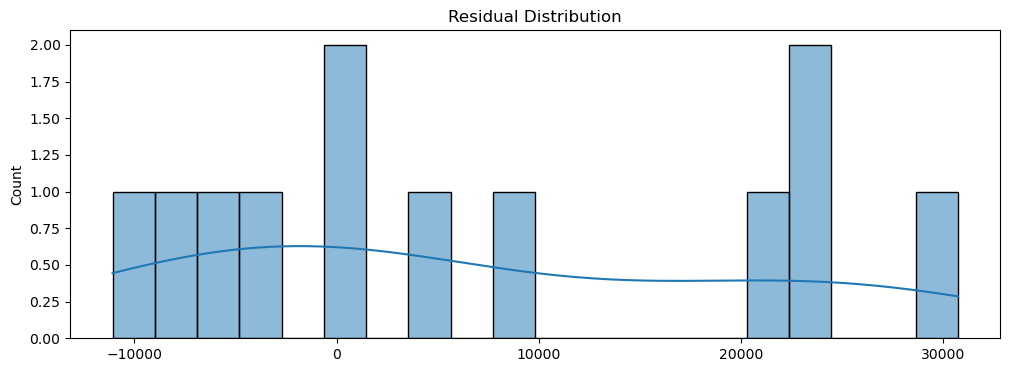

In [39]:
plt.figure(figsize=(12,4))
sns.histplot(residual, bins=20, kde=True)
plt.title("Residual Distribution")
plt.show()

### R² (Coefficient of Determination)

In [40]:
y_mean = y_test.mean()

SSE = ((y_test - y_pred) ** 2).sum()
TSS = ((y_test - y_mean) ** 2).sum()
R2  = 1 - (SSE / TSS)

print(f"Sum of Squared Errors (SSE): {SSE:.3f}")
print(f"Total Sum of Squares (TSS): {TSS:.3f}")
print(f"R² (Explained Variance): {R2:.3f}")

Sum of Squared Errors (SSE): 2791680479.048
Total Sum of Squares (TSS): 7971273313.117
R² (Explained Variance): 0.650


## 10. Prophet Model for Final Forecasting

1. Trained on the entire historical data.
2. Used for future forecasting and dashboard predictions.

In [41]:
X_prophet = (
    monthly_sales
    .rename(columns = {
        "Order Date": "ds",
        "Sales": "y"
    })
    .sort_values("ds")
)

model = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    interval_width = confidence_interval
)

model.fit(X_prophet)
future = model.make_future_dataframe(periods=6, freq="ME")
forecast = model.predict(future)
state_holder["forecast"] = forecast

INFO: Chain [1] start processing
INFO: Chain [1] done processing


### Category-wise Sales Forecast

In [42]:
category_forecasts = []

# Train a separate Prophet model for each product category
for category in df["Category"].unique():
    temp = df[df["Category"] == category]
    
    monthly_cat = (
        temp
        .groupby(pd.Grouper(key="Order Date", freq="ME"))["Sales"]
        .sum()
        .reset_index()
    )
    
    if len(monthly_cat) < 24:
        continue
    
    prophet_cat = monthly_cat.rename(
        columns={"Order Date": "ds", "Sales": "y"}
    )
    
    model_cat = Prophet(
        yearly_seasonality = True,
        weekly_seasonality = False,
        daily_seasonality = False,
    )
    model_cat.fit(prophet_cat)
    
    future_cat = model_cat.make_future_dataframe(periods=6, freq="ME")
    forecast_cat = model_cat.predict(future_cat)
    
    forecast_cat["Category"] = category
    category_forecasts.append(
        forecast_cat[["ds", "yhat", "yhat_lower", "yhat_upper", "Category"]]
    )

category_forecast_df = pd.concat(category_forecasts)

# Store category-wise Prophet forecasts for application usage
state_holder["category_forecast_df"] = category_forecast_df

INFO: Chain [1] start processing
INFO: Chain [1] done processing
INFO: Chain [1] start processing
INFO: Chain [1] done processing
INFO: Chain [1] start processing
INFO: Chain [1] done processing


In [43]:
# Save application state for Streamlit usage

with open(state_path, "wb") as f:
    pickle.dump(state_holder, f)